In [1]:
!pip install nba_api

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from nba_api.stats.endpoints import teamgamelog, leaguedashplayerstats, playergamelog
from nba_api.stats.static import teams

In [3]:
# General Team Info
nba_teams = teams.get_teams()

team_dict = {team['full_name']: team['id'] for team in nba_teams}
team_ids = [team['id'] for team in nba_teams]
team_df = pd.DataFrame(nba_teams)

team_df.head()

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Georgia,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [4]:
full_gamelog = pd.read_csv('full_gamelog.csv')
full_player_gamelog = pd.read_csv('full_player_gamelog.csv')
full_player_stats = pd.read_csv('full_player_stats.csv')
seasons = ['2020-21', '2021-22', '2022-23', '2023-24']

In [5]:
# Game Stats
seasons = ['2020-21', '2021-22', '2022-23', '2023-24']
gamelogs = []
for team_id in team_ids:
    for season in seasons:
        try:
            gamelog = teamgamelog.TeamGameLog(team_id=team_id, season=season).get_data_frames()[0]
            gamelogs.append(gamelog)
        except Exception as e:
            print(f"Error fetching data for Team ID: {team_id}, Season: {season}: {e}")
        time.sleep(1)

full_gamelog = pd.concat(gamelogs, ignore_index=True)
safe = full_gamelog
print(full_gamelog.info())
full_gamelog.head()

In [6]:
# #Player Stats
def season_to_id(season):
    start_year = int(season.split("-")[0])
    return f"2{start_year}"

player_stats_seasons = []

for season in seasons:
    player_stats = leaguedashplayerstats.LeagueDashPlayerStats(season=season).get_data_frames()[0]
    player_stats['SEASON_ID'] = season_to_id(season)  # Add SEASON_ID column
    player_stats_seasons.append(player_stats)

full_player_stats = pd.concat(player_stats_seasons, ignore_index=True)

print(full_player_stats.info())
full_player_stats.head()

In [7]:
# Player-Game Info
player_ids = full_player_stats['PLAYER_ID'].unique()
player_gamelogs = []

for player_id in tqdm(player_ids, desc="Fetching player game logs"):
    for season in seasons:
        try:
            player_log = playergamelog.PlayerGameLog(player_id=player_id, season=season).get_data_frames()[0]
            player_gamelogs.append(player_log)
        except Exception as e:
            print(f"Error fetching player game logs for Player ID: {player_id}, Season: {season}: {e}")
        time.sleep(1)

full_player_gamelog = pd.concat(player_gamelogs, ignore_index=True)
safe1 = full_player_gamelog

print(full_player_gamelog.info())
full_player_gamelog.head()

In [8]:
# Transform WL to 0 for loss, 1 for win
full_gamelog['WL'] = full_gamelog['WL'].astype(str).str.strip().str.upper()
full_gamelog['WL'] = full_gamelog['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Convert GAME_DATE to datetime format
full_gamelog['GAME_DATE'] = pd.to_datetime(full_gamelog['GAME_DATE'])
full_player_gamelog['GAME_DATE'] = pd.to_datetime(full_player_gamelog['GAME_DATE'])

In [9]:
# Create home/away status, opponent, and team cols
# For Home/Away col, 0 means home and 1 means away
def transform_matchup(row):
    if 'vs.' in row['MATCHUP']:
        parts = row['MATCHUP'].split(' vs. ')
        return pd.Series([parts[0], parts[1], 0])
    elif '@' in row['MATCHUP']:
        parts = row['MATCHUP'].split(' @ ')
        return pd.Series([parts[0], parts[1], 1])

full_gamelog[['TEAM_ABBR', 'OPPONENT_ABBR', 'HOME/AWAY']] = full_gamelog.apply(transform_matchup, axis=1)
full_gamelog[['MATCHUP', 'TEAM_ABBR', 'OPPONENT_ABBR', 'HOME/AWAY']].head()

,MATCHUP,TEAM_ABBR,OPPONENT_ABBR,HOME/AWAY
0,ATL vs. HOU,ATL,HOU,0
1,ATL vs. ORL,ATL,ORL,0
2,ATL vs. WAS,ATL,WAS,0
3,ATL vs. WAS,ATL,WAS,0
4,ATL @ IND,ATL,IND,1


In [10]:
full_player_gamelog[['TEAM_ABBR', 'OPPONENT_ABBR', 'HOME/AWAY']] = full_player_gamelog.apply(transform_matchup, axis=1)
full_player_gamelog[['MATCHUP', 'TEAM_ABBR', 'OPPONENT_ABBR', 'HOME/AWAY']].head()

,MATCHUP,TEAM_ABBR,OPPONENT_ABBR,HOME/AWAY
0,DEN @ POR,DEN,POR,1
1,DEN @ MIN,DEN,MIN,1
2,DEN @ CHA,DEN,CHA,1
3,DEN @ UTA,DEN,UTA,1
4,DEN vs. NYK,DEN,NYK,0


In [11]:
print(full_gamelog.info())
print(full_player_gamelog.info())
print(full_player_stats.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Team_ID        9540 non-null   int64         
 1   Game_ID        9540 non-null   int64         
 2   GAME_DATE      9540 non-null   datetime64[ns]
 3   MATCHUP        9540 non-null   object        
 4   WL             9540 non-null   int64         
 5   W              9540 non-null   int64         
 6   L              9540 non-null   int64         
 7   W_PCT          9540 non-null   float64       
 8   MIN            9540 non-null   int64         
 9   FGM            9540 non-null   int64         
 10  FGA            9540 non-null   int64         
 11  FG_PCT         9540 non-null   float64       
 12  FG3M           9540 non-null   int64         
 13  FG3A           9540 non-null   int64         
 14  FG3_PCT        9540 non-null   float64       
 15  FTM            9540 n

In [12]:
print(full_gamelog.head())
print(full_player_gamelog.head())
print(full_player_stats.head())

      Team_ID   Game_ID  GAME_DATE      MATCHUP  WL   W   L  W_PCT  MIN  FGM  \
0  1610612737  22001066 2021-05-16  ATL vs. HOU   1  41  31  0.569  240   49   
1  1610612737  22001049 2021-05-13  ATL vs. ORL   1  40  31  0.563  240   41   
2  1610612737  22001042 2021-05-12  ATL vs. WAS   1  39  31  0.557  240   44   
3  1610612737  22001026 2021-05-10  ATL vs. WAS   1  38  31  0.551  240   46   
4  1610612737  22001000 2021-05-06    ATL @ IND   0  37  31  0.544  240   48   

   ...  REB  AST  STL  BLK  TOV  PF  PTS  TEAM_ABBR  OPPONENT_ABBR  HOME/AWAY  
0  ...   56   32   10    8   13  16  124        ATL            HOU          0  
1  ...   49   19    9    4    7  16  116        ATL            ORL          0  
2  ...   51   22    4    5   14  21  120        ATL            WAS          0  
3  ...   55   23    4    6   12  17  125        ATL            WAS          0  
4  ...   34   27    8    6   12  17  126        ATL            IND          1  

[5 rows x 30 columns]
   SEASON_ID  Pl

In [13]:
# Check for nans and duplicates
print("Missing values in player stats:")
print(full_player_stats.isnull().sum())

print("\nMissing values in game logs:")
print(full_gamelog.isnull().sum())

print("\nMissing values in player-game log:")
print(full_player_stats.isnull().sum())

print("\nDuplicates in player stats:", full_player_stats.duplicated().sum())
print("Duplicates in game logs:", full_gamelog.duplicated().sum())
print("Duplicates in player-game logs:", full_player_gamelog.duplicated().sum())

Missing values in player stats:
PLAYER_ID                0
PLAYER_NAME              0
NICKNAME                 0
TEAM_ID                  0
TEAM_ABBREVIATION        0
                        ..
NBA_FANTASY_PTS_RANK     0
DD2_RANK                 0
TD3_RANK                 0
WNBA_FANTASY_PTS_RANK    0
SEASON_ID                0
Length: 67, dtype: int64

Missing values in game logs:
Team_ID          0
Game_ID          0
GAME_DATE        0
MATCHUP          0
WL               0
W                0
L                0
W_PCT            0
MIN              0
FGM              0
FGA              0
FG_PCT           0
FG3M             0
FG3A             0
FG3_PCT          0
FTM              0
FTA              0
FT_PCT           0
OREB             0
DREB             0
REB              0
AST              0
STL              0
BLK              0
TOV              0
PF               0
PTS              0
TEAM_ABBR        0
OPPONENT_ABBR    0
HOME/AWAY        0
dtype: int64

Missing values in player-game lo

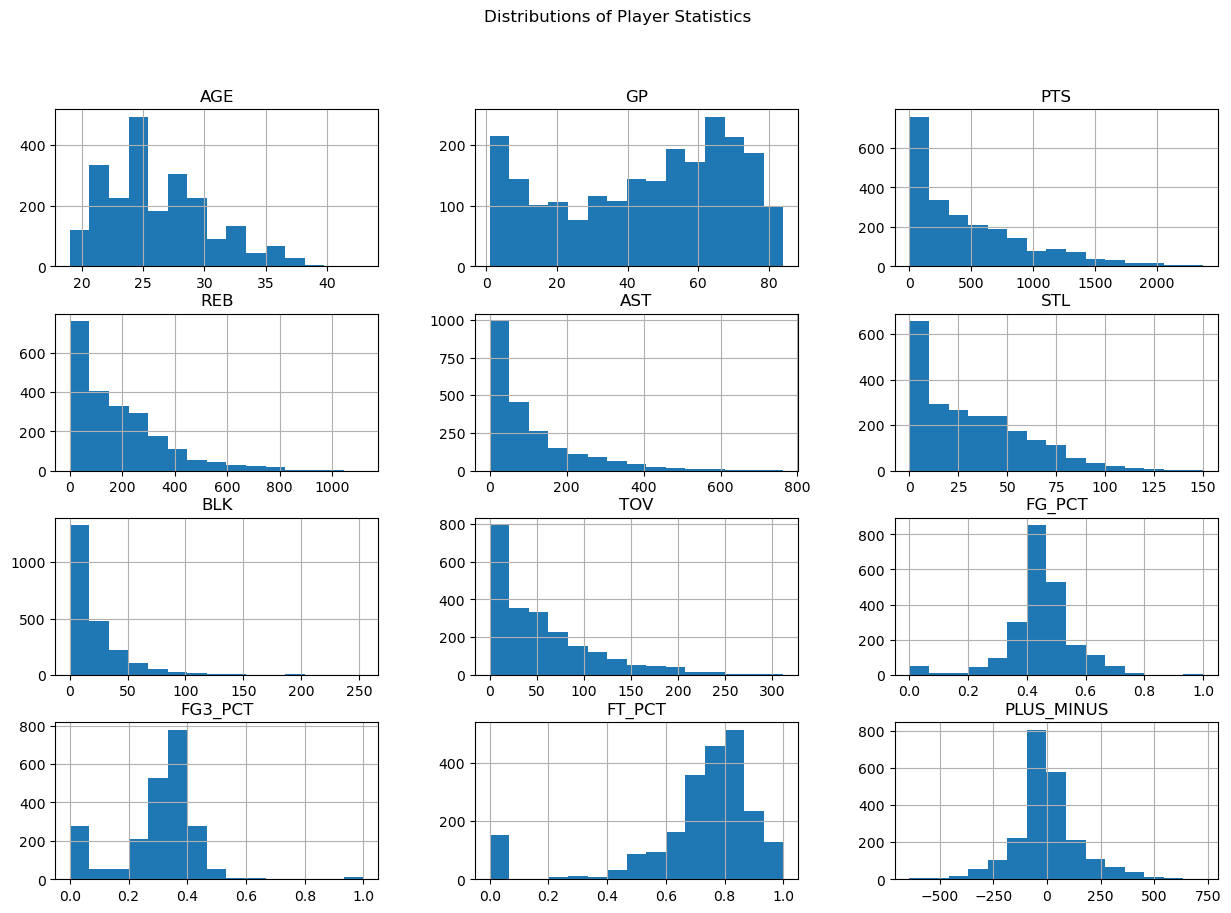

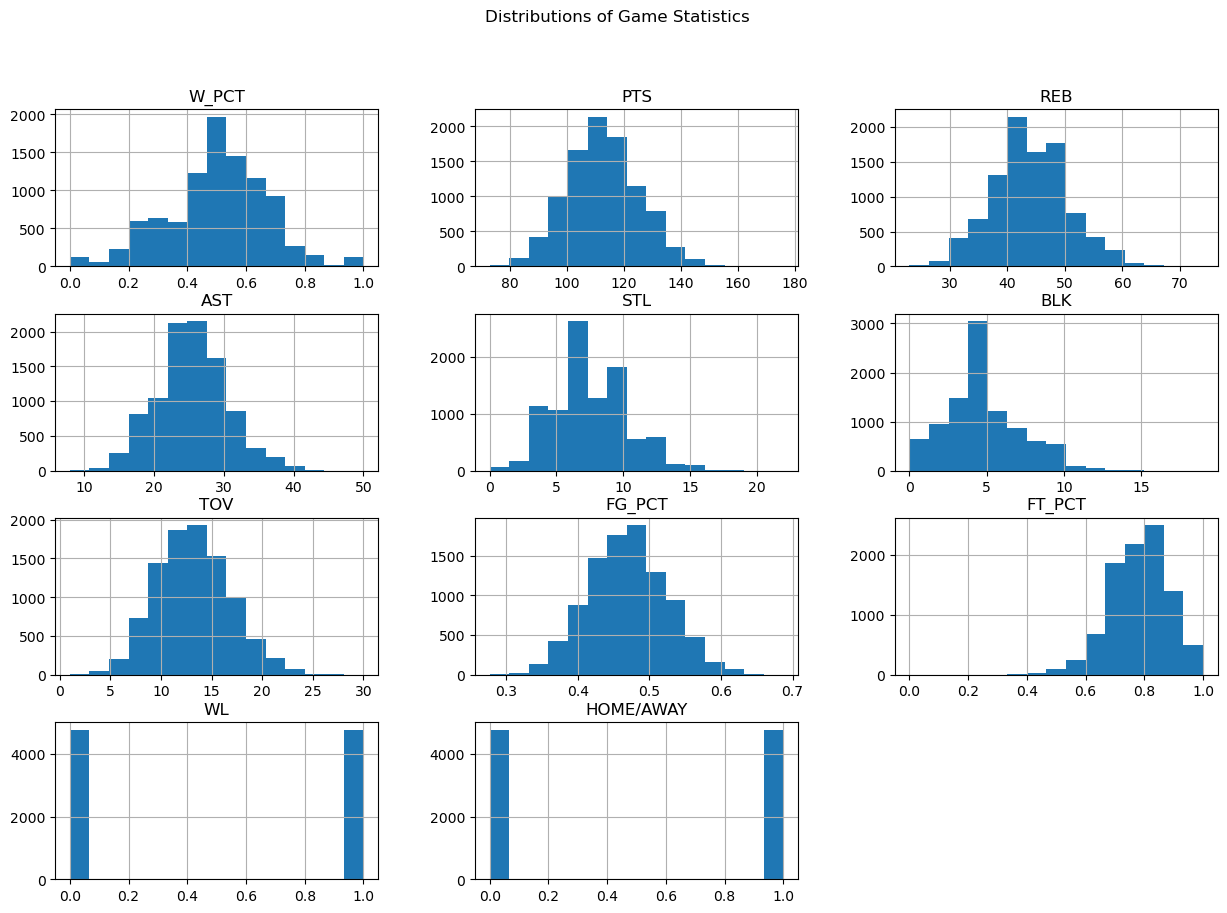

In [14]:
# Player statistics distributions
numeric_cols = ['AGE', 'GP', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS']
full_player_stats[numeric_cols].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distributions of Player Statistics")
plt.show()

# Team statistics distributions
game_log_numeric_cols = ['W_PCT', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FG_PCT', 'FT_PCT', 'WL', 'HOME/AWAY']
full_gamelog[game_log_numeric_cols].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distributions of Game Statistics")
plt.show()

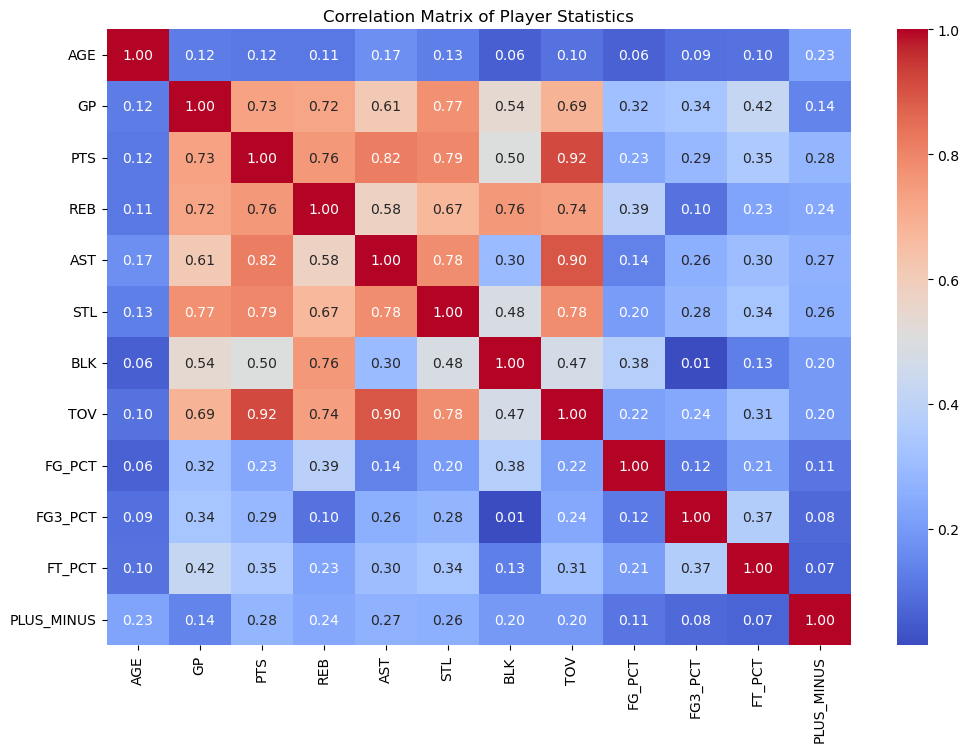

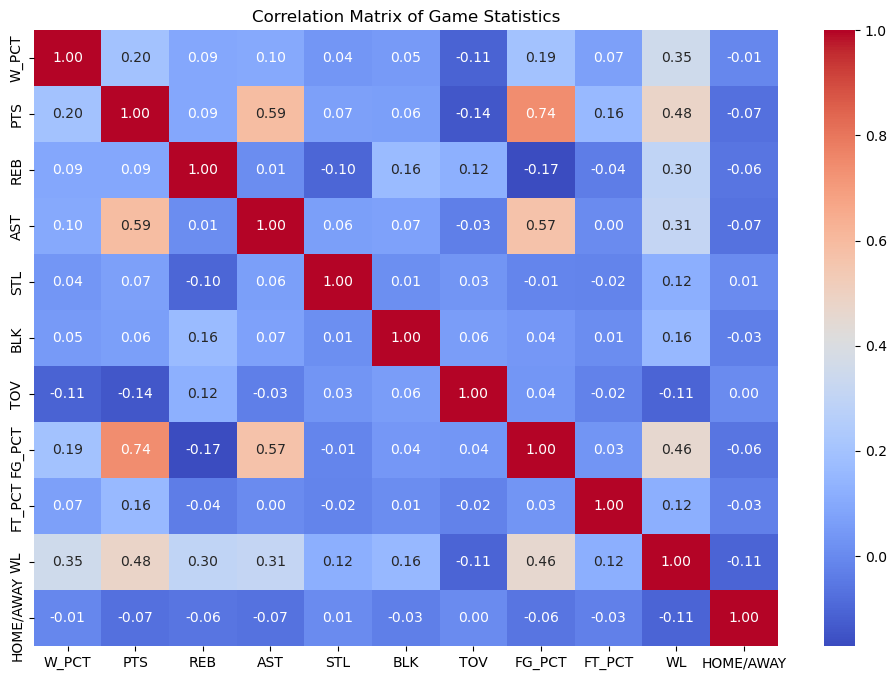

In [15]:
# Correlation matrix for player statistics
player_corr = full_player_stats[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(player_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Player Statistics")
plt.show()

# Correlation matrix for team statistics
game_log_corr = full_gamelog[game_log_numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(game_log_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Game Statistics")
plt.show()

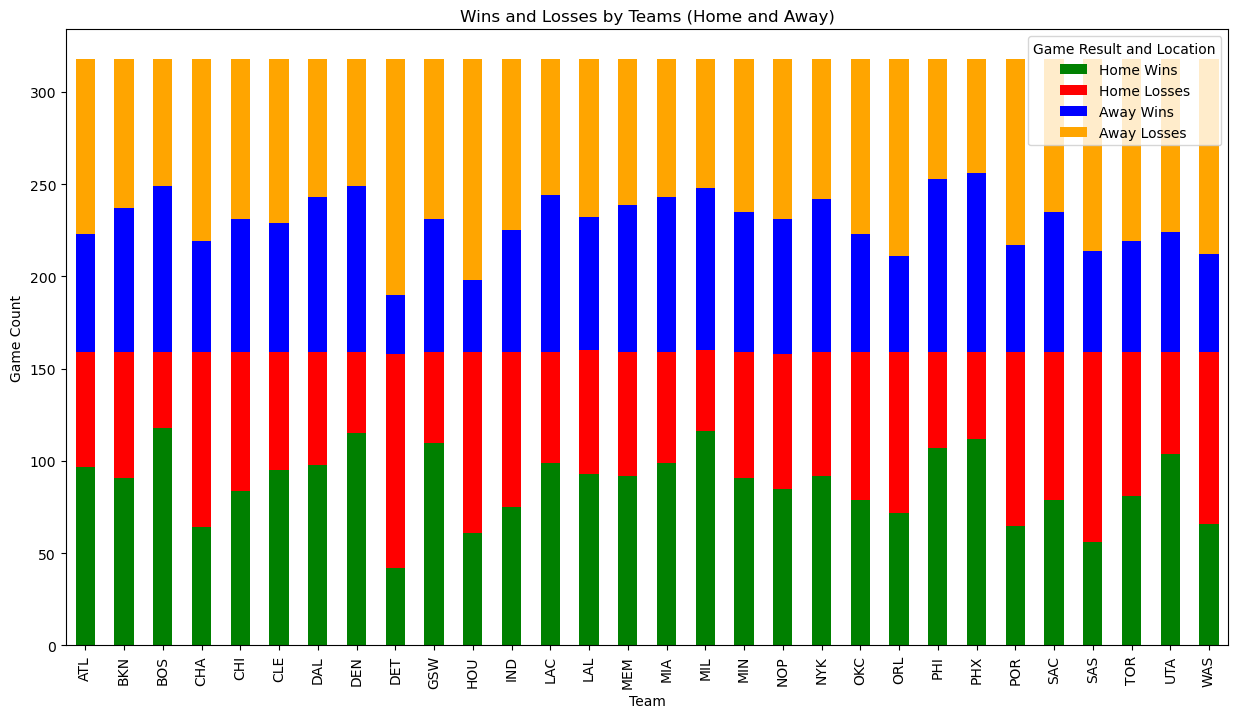

In [16]:
# Home and away wins and losses
home_wins = full_gamelog[(full_gamelog['HOME/AWAY'] == 0) & (full_gamelog['WL'] == 1)]['TEAM_ABBR'].value_counts()
home_losses = full_gamelog[(full_gamelog['HOME/AWAY'] == 0) & (full_gamelog['WL'] == 0)]['TEAM_ABBR'].value_counts()
away_wins = full_gamelog[(full_gamelog['HOME/AWAY'] == 1) & (full_gamelog['WL'] == 1)]['TEAM_ABBR'].value_counts()
away_losses = full_gamelog[(full_gamelog['HOME/AWAY'] == 1) & (full_gamelog['WL'] == 0)]['TEAM_ABBR'].value_counts()

team_results = pd.DataFrame({
    'Home Wins': home_wins,
    'Home Losses': home_losses,
    'Away Wins': away_wins,
    'Away Losses': away_losses
}).fillna(0)

team_results.plot(kind='bar', figsize=(15, 8), stacked=True,
                  color=['green', 'red', 'blue', 'orange'])
plt.title("Wins and Losses by Teams (Home and Away)")
plt.xlabel("Team")
plt.ylabel("Game Count")
plt.legend(title="Game Result and Location")
plt.show()

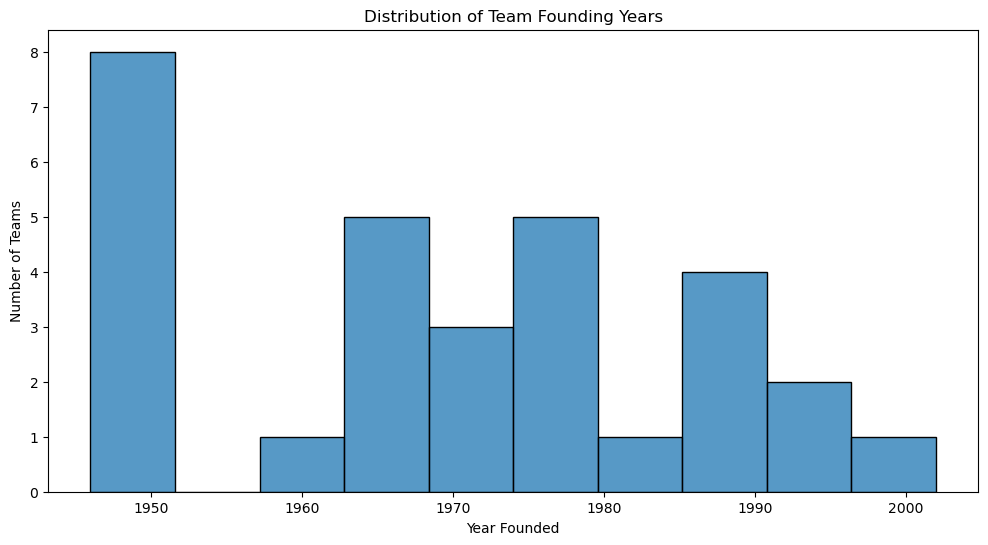

In [17]:
# Team founding year
plt.figure(figsize=(12, 6))
sns.histplot(team_df['year_founded'], bins=10)
plt.title("Distribution of Team Founding Years")
plt.xlabel("Year Founded")
plt.ylabel("Number of Teams")
plt.show()

In [18]:
# Final df for modeling
final_log = pd.merge(
    full_player_gamelog,
    full_player_stats,
    left_on=['Player_ID', 'TEAM_ABBR', 'SEASON_ID'],
    right_on=['PLAYER_ID', 'TEAM_ABBREVIATION', 'SEASON_ID'],
    how='left',
    suffixes=('_game', '_career') 
)

final_log

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN_game,FGM_game,FGA_game,FG_PCT_game,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK
0,22020,203932,22001076,2021-05-16,DEN @ POR,0,12,1,4,0.250,...,102.0,409.0,314.0,95.0,156.0,124.0,150.0,115.0,17.0,152.0
1,22020,203932,22001052,2021-05-13,DEN @ MIN,0,30,6,10,0.600,...,102.0,409.0,314.0,95.0,156.0,124.0,150.0,115.0,17.0,152.0
2,22020,203932,22000448,2021-05-11,DEN @ CHA,0,29,8,14,0.571,...,102.0,409.0,314.0,95.0,156.0,124.0,150.0,115.0,17.0,152.0
3,22020,203932,22001008,2021-05-07,DEN @ UTA,0,30,5,9,0.556,...,102.0,409.0,314.0,95.0,156.0,124.0,150.0,115.0,17.0,152.0
4,22020,203932,22000995,2021-05-05,DEN vs. NYK,0,22,0,6,0.000,...,102.0,409.0,314.0,95.0,156.0,124.0,150.0,115.0,17.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99185,22023,1641705,22300131,2023-11-02,SAS @ PHX,0,34,15,26,0.577,...,1.0,382.0,483.0,9.0,28.0,491.0,7.0,10.0,10.0,10.0
99186,22023,1641705,22300113,2023-10-31,SAS @ PHX,0,28,6,12,0.500,...,1.0,382.0,483.0,9.0,28.0,491.0,7.0,10.0,10.0,10.0
99187,22023,1641705,22300099,2023-10-29,SAS @ LAC,0,26,4,10,0.400,...,1.0,382.0,483.0,9.0,28.0,491.0,7.0,10.0,10.0,10.0
99188,22023,1641705,22300083,2023-10-27,SAS vs. HOU,0,31,7,19,0.368,...,1.0,382.0,483.0,9.0,28.0,491.0,7.0,10.0,10.0,10.0


In [21]:
final_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99190 entries, 0 to 99189
Data columns (total 96 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SEASON_ID              99190 non-null  int64         
 1   Player_ID              99190 non-null  int64         
 2   Game_ID                99190 non-null  int64         
 3   GAME_DATE              99190 non-null  datetime64[ns]
 4   MATCHUP                99190 non-null  object        
 5   WL                     99190 non-null  int64         
 6   MIN_game               99190 non-null  int64         
 7   FGM_game               99190 non-null  int64         
 8   FGA_game               99190 non-null  int64         
 9   FG_PCT_game            99190 non-null  float64       
 10  FG3M_game              99190 non-null  int64         
 11  FG3A_game              99190 non-null  int64         
 12  FG3_PCT_game           99190 non-null  float64       
 13  F

In [22]:
# Rearrange cols and drop duplicates.inf
final_log = final_log.drop(columns=['PLAYER_ID', 'TEAM_ABBREVIATION'])

column_order = [
    # Identifiers
    'Game_ID', 'Player_ID', 'PLAYER_NAME', 'TEAM_ABBR', 'OPPONENT_ABBR', 'HOME/AWAY', 'GAME_DATE', 'MATCHUP', 'WL',
    
    # Game-specific stats
    'MIN_game', 'FGM_game', 'FGA_game', 'FG_PCT_game', 'FG3M_game', 'FG3A_game', 'FG3_PCT_game',
    'FTM_game', 'FTA_game', 'FT_PCT_game', 'OREB_game', 'DREB_game', 'REB_game', 'AST_game', 
    'STL_game', 'BLK_game', 'TOV_game', 'PF_game', 'PTS_game', 'PLUS_MINUS_game', 'VIDEO_AVAILABLE',
    
    # Career-specific stats
    'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN_career', 'FGM_career', 'FGA_career', 'FG_PCT_career',
    'FG3M_career', 'FG3A_career', 'FG3_PCT_career', 'FTM_career', 'FTA_career', 'FT_PCT_career',
    'OREB_career', 'DREB_career', 'REB_career', 'AST_career', 'STL_career', 'BLK_career', 
    'TOV_career', 'PF_career', 'PTS_career', 'PLUS_MINUS_career', 'NBA_FANTASY_PTS', 'DD2', 'TD3',
    
    # Rankings
    'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK',
    'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK',
    'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
    'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK'
]

final_log = final_log[column_order]

final_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99190 entries, 0 to 99189
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Game_ID               99190 non-null  int64         
 1   Player_ID             99190 non-null  int64         
 2   PLAYER_NAME           90390 non-null  object        
 3   TEAM_ABBR             99190 non-null  object        
 4   OPPONENT_ABBR         99190 non-null  object        
 5   HOME/AWAY             99190 non-null  int64         
 6   GAME_DATE             99190 non-null  datetime64[ns]
 7   MATCHUP               99190 non-null  object        
 8   WL                    99190 non-null  int64         
 9   MIN_game              99190 non-null  int64         
 10  FGM_game              99190 non-null  int64         
 11  FGA_game              99190 non-null  int64         
 12  FG_PCT_game           99190 non-null  float64       
 13  FG3M_game       

In [26]:
final_log.to_csv('final_log.csv', index=False)